# Setup

In [26]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [28]:
# Load data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="../data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="../data", train=False, transform=transform, download=True)

In [29]:
batch_size = 1000
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# Training

In [30]:
# Model

class DigitNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, X):
        x = self.pool1(F.relu(self.conv1(X))) # 1x28x28 --> convolution --> 32x28x28 -->  maxpool --> 32x14x14
        x = self.pool2(F.relu(self.conv2(x))) # 32x14x14 --> convolution --> 64x14x14 --> maxpool --> 64x7x7
        x = x.view(-1, 64 * 7 * 7) # 64x7x7 --> 3136
        x = F.relu(self.fc1(x)) # 3136 --> 128
        x = self.fc2(x) # 128 --> 10
        return x

In [31]:
model = DigitNet().to(device)
model

DigitNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [32]:
print(f"Parameter count: {sum(p.numel() for p in model.parameters())}")

Parameter count: 421642


In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.001)

In [34]:
# Initialize metrics

metrics = {}
metrics["model"] = str(model)
metrics["train_losses"] = []
metrics["train_accuracies"] = []
metrics["test_losses"] = []
metrics["test_accuracies"] = []

metrics

{'model': 'DigitNet(\n  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))\n  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (fc1): Linear(in_features=3136, out_features=128, bias=True)\n  (fc2): Linear(in_features=128, out_features=10, bias=True)\n)',
 'train_losses': [],
 'train_accuracies': [],
 'test_losses': [],
 'test_accuracies': []}

In [35]:
def train_step():
    model.train()

    train_loss = 0.0
    train_acc = 0.0

    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        y_logits = model(X)
        y_pred_probs = torch.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_pred_probs, dim=1)

        # Loss
        loss = criterion(y_logits, y)
        train_loss += loss
        metrics["train_losses"].append(loss.item())

        # Accuracy
        acc = (y_preds == y).sum().item() / len(y)
        train_acc += acc
        metrics["train_accuracies"].append(acc)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    return train_loss, train_acc

In [36]:
def test_step():
    model.eval()

    test_loss = 0.0
    test_acc = 0.0

    for batch, (X, y) in enumerate(test_dataloader):
        X = X.to(device)
        y = y.to(device)

        # Forward pass
        y_logits = model(X)
        y_pred_probs = torch.softmax(y_logits, dim=1)
        y_preds = torch.argmax(y_pred_probs, dim=1)

        # Loss
        loss = criterion(y_logits, y)
        test_loss += loss
        metrics["test_losses"].append(loss.item())

        # Accuracy
        acc = (y_preds == y).sum().item() / len(y)
        test_acc += acc
        metrics["test_accuracies"].append(acc)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    return test_loss, test_acc

In [37]:
# Training

epochs = 2
epoch_print_interval = 1

for epoch in range(epochs):
    train_loss, train_acc = train_step()
    test_loss, test_acc = test_step()

    if epoch % epoch_print_interval == 0 or epoch == epochs-1:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.4f}% | Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.4f}%")

Epoch: 0 | Train Loss: 0.6145 | Train Acc: 83.9033% | Test Loss: 0.1818 | Test Acc: 94.8000%
Epoch: 1 | Train Loss: 0.1350 | Train Acc: 96.0950% | Test Loss: 0.0892 | Test Acc: 97.0900%


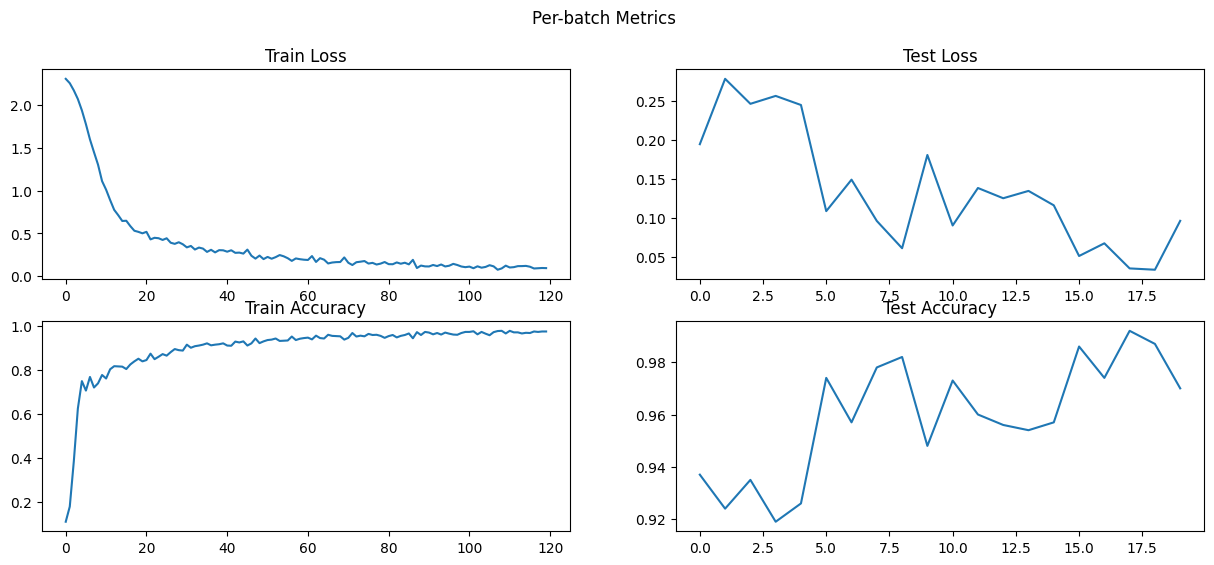

In [43]:
def plot_metrics(metrics: dict):
    x_tr = range(0, len(metrics["train_losses"]))
    x_te = range(0, len(metrics["test_losses"]),)

    plt.figure(figsize=(15, 6))

    plt.subplot(2, 2, 1)
    plt.title("Train Loss")
    plt.plot(x_tr, metrics["train_losses"], label="Train Losses")

    plt.subplot(2, 2, 2)
    plt.title("Test Loss")
    plt.plot(x_te, metrics["test_losses"], label="Test Losses")

    plt.subplot(2, 2, 3)
    plt.title("Train Accuracy")
    plt.plot(x_tr, metrics["train_accuracies"], label="Train Accuracies")

    plt.subplot(2, 2, 4)
    plt.title("Test Accuracy")
    plt.plot(x_te, metrics["test_accuracies"], label="Test Accuracies")

    plt.suptitle("Per-batch Metrics")
    plt.show()

plot_metrics(metrics)

Since the model learns pretty much everything after only 1 epoch of training, we used per-batch metrics instead of per-epoch.

Test curve looks jagged because of small batch count.

In [46]:
print(f"Lowest loss on test dataset: {min(metrics['test_losses']):.4f}")
print(f"Highest accuracy on test dataset: {max(metrics['test_accuracies'])*100:.2f}%")

Lowest loss on test dataset: 0.0340
Highest accuracy on test dataset: 99.20%


# Save the Model

In [48]:
torch.save(model, "model.pth")